<a href="https://colab.research.google.com/github/kanishk16/Stepping-Up-with-CV/blob/master/Bubble_Sheet_MCQ_Scanner_and_Test_Grader_using_OMR_(Day_04).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Optical Mark Recognition(OMR)
> process of automatically analyzing human-marked documents and interpreting their results

In [0]:
# neccessary imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
from imutils.perspective import four_point_transform
import imutils
from google.colab.patches import cv2_imshow as cv_imshow

# version check
cv.__version__

'3.4.3'

> Steps to build a bubble sheet scanner and grader - 

1. Detect the exam sheet in the image.
2. Apply a perspective transform to extract the top-down, birds-eye-view of the exam.
3. Extract the set of bubbles (i.e., the possible choices) from the perspective transformed exam.
4. Sort the questions/bubbles into rows. (WHY and HOW can we diff. between them??)
5. Determine the marked (i.e., “bubbled in”) answer for each row.
6. Lookup the correct answer in our answer key to determine if the user was   correct in their choice.
7. Repeat for all questions in the exam.


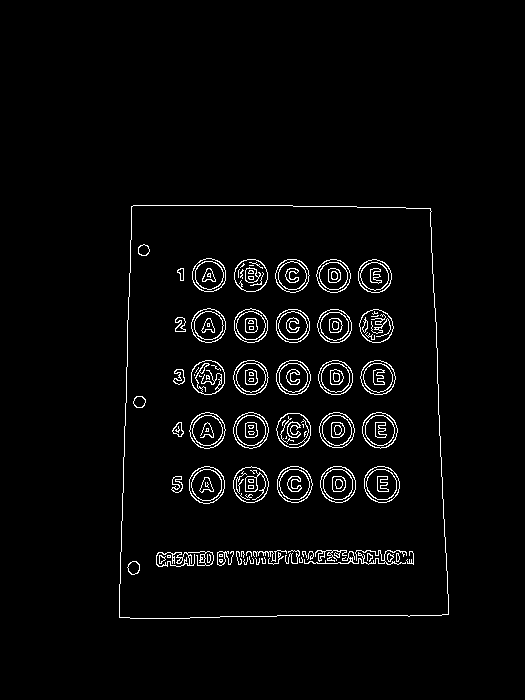

In [0]:
# Define the answer key- Ques1: B; Ques2: E; Ques3: A.....
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

# Detecting the exam sheet in an img (edge detection)
img = cv.imread('test_01.png')

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

img_blur = cv.GaussianBlur(img_gray, (5,5), 0)

img_edge = cv.Canny(img_blur, 30, 150)

cv_imshow(img_edge)

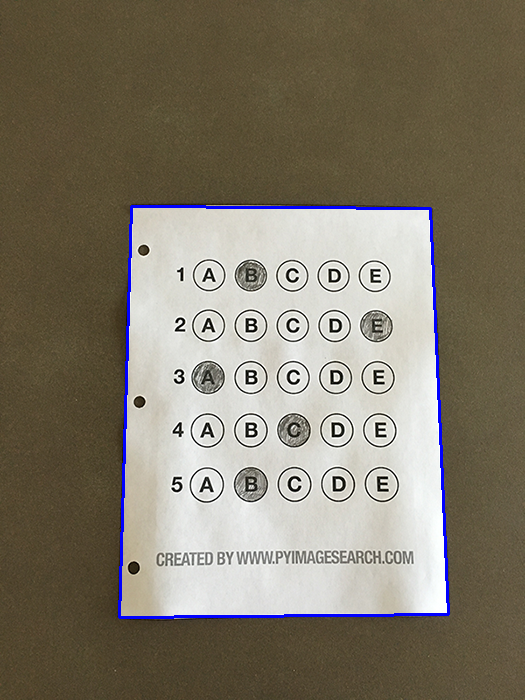

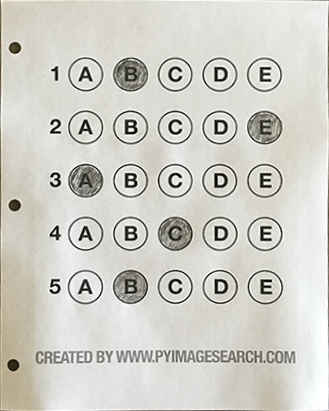

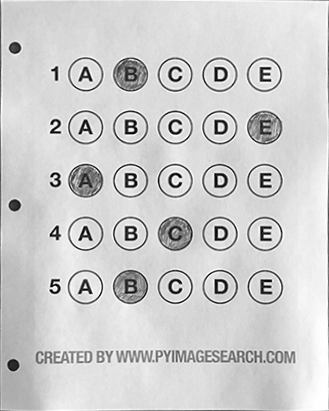

In [37]:
# find the contours in the binary img.
img_contours = cv.findContours(img_edge, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[1]

# initialize the contours corresponding to the doc
docimg_contours = None

# 
if len(img_contours)>0:
  # sort the contours in desc acc. to their size
  img_contours = sorted(img_contours, key = cv.contourArea, reverse=True)

  # loop over the contours(sorted) to detect ONLY the exam sheet
  for c in img_contours:
    # approximate the contours
    perimeter = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.02*perimeter, True)

    if len(approx) == 4:
      docimg_contours = approx
      break

# visualize the contour on the img.
# img_doc = cv.drawContours(img.copy(), docimg_contours, -1, (255,0,0), 3)  #OUTPUT: highlights only the pts. specifically 
img_doc = cv.drawContours(img.copy(), [docimg_contours], -1, (255,0,0), 2)
cv_imshow(img_doc)

# apply four point transform to obtain a top-view
orig_img = four_point_transform(img.copy(), docimg_contours.reshape(4,2))
cv_imshow(orig_img)

gray_img = four_point_transform(img_gray.copy(), docimg_contours.reshape(4,2))
cv_imshow(gray_img)

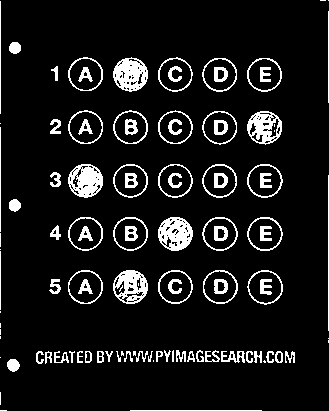

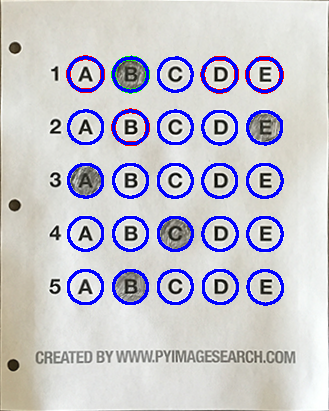

In [35]:
# thresholding/segmenting the foreground from the background of the img.
thresh_img = cv.threshold(gray_img.copy(), 0, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)[1]
cv_imshow(thresh_img)

# find the contours in the binary img.
img_contours = cv.findContours(thresh_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[1]
ques_contours=[]

for c in img_contours:
  # compute the bounding box + aspect ratio
  (x, y, w, h) = cv.boundingRect(c)
  ar = w / float(h)

  # label region: ques_contour - region width,height + aspect ratio ~ 1
  if w>=20 and h>=20 and ar>=0.9 and ar<=1.1:
    ques_contours.append(c)

ques_img = cv.drawContours(orig_img.copy(), ques_contours, -1, (255,0,0), 2)
cv_imshow(ques_img)

0


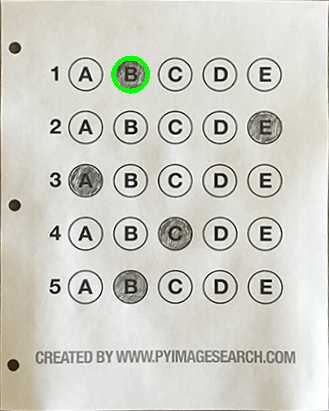

5


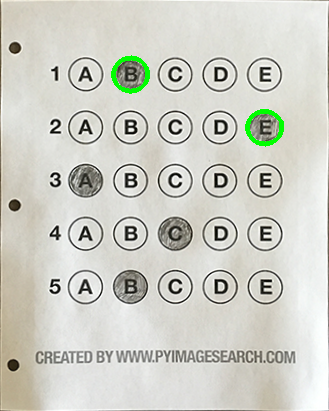

10


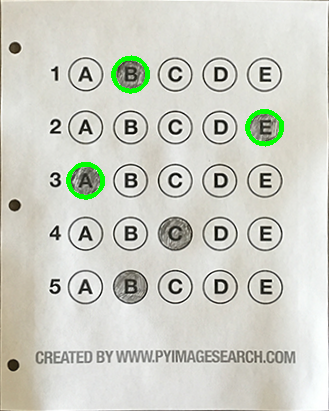

15


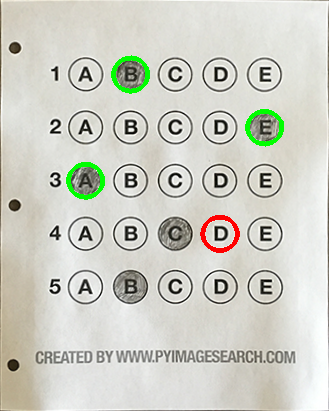

20


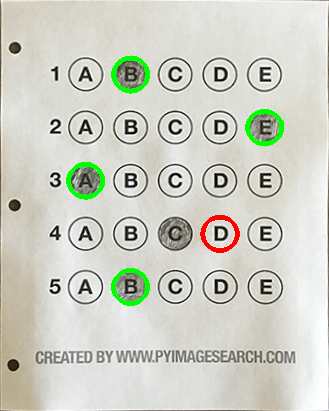

In [38]:
# sort the ques_contours from top-to-bottom
ques_contours = contours.sort_contours(ques_contours, 'top-to-bottom')[0]

# correct ans
correct = 0

# loop over ques in batches of 5
for q,i in enumerate(np.arange(0, len(ques_contours), 5)):
  # sort the contours for the current ques
  print(i)
  cntrs = contours.sort_contours(ques_contours[i: i+5])[0]
  bubbled = None

  # determining the filled bubble
  for j,c in enumerate(cntrs):
    # mask revealing only the bubble for the current ques
    mask = np.zeros(thresh_img.shape, dtype='uint8')
    _mask_img = cv.drawContours(mask, [c], -1, 255, -1)
    # cv_imshow(_mask_img)      # OUTPUT: white bubble for the current option selected

    # apply the mask to the thresholded img + count the num of non-zero px in the bubble area
    mask = cv.bitwise_and(thresh_img, thresh_img, mask=mask)
    # cv_imshow(mask)
    n = cv.countNonZero(mask)

    # updating bubbled based on the total num of non-zero px
    if bubbled is None or n > bubbled[0]:
      bubbled = (n, j)
      # print(bubbled)

  color = (0,0,255)
  k = ANSWER_KEY[q]

  # check for correct ans
  if k==bubbled[1]:
    color = (0,255,0)
    correct +=1
  
  key_img = cv.drawContours(orig_img, [cntrs[k]], -1, color, 3)
  cv_imshow(key_img)
  # break

* Why HOUGHES CIRCLE detection not preferred?
> Hough circles would totally fail in cases where you overdo the darkening of the bubbles as it doesn’t handle deformations in their outlines very well 